In [2]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx

# load fif file
import mne
mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')

Opening raw data file ../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif...
Isotrak not found
    Range : 0 ... 2000 =      0.000 ...     1.000 secs
Ready.


C:\Users\zhouz\AppData\Local\Temp\ipykernel_26192\3171993334.py:25: RuntimeWarning: This filename (../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


In [1]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]
freq7colors = [black, red, deepyellow, darkgreen, matlab_blue, blue, matlab_purple]

color_4st=[matlab_green,red,blue,black]

In [3]:
# def matrixplot(data,title):
# 	plt.figure()
# 	plt.imshow(data,vmin =-0.3,vmax = 0.3, cmap = 'jet')
# 	plt.colorbar()
# 	plt.title(title)
# 	plt.xticks(range(32),labels = labels,rotation = 'vertical')
# 	plt.yticks(range(32),labels = labels,rotation = 'horizontal')

In [3]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [4]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [5]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [6]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [11]:
# #organize the correlation matrices
# R_follow_synco = np.zeros((36,7,32,32)) # "R" stands for "Correlation Matrices" here
# R_lead_synco = np.zeros((36,7,32,32))
# R_ind_synco = np.zeros((36,7,32,32))
# R_mutual_synco = np.zeros((36,7,32,32))
# R_follow_synch = np.zeros((36,7,32,32))
# R_lead_synch = np.zeros((36,7,32,32))
# R_ind_synch = np.zeros((36,7,32,32))
# R_mutual_synch = np.zeros((36,7,32,32))

# R_follow_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:] # L-following in R_Lead condition
# R_follow_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:] # R-following in L_Lead condition
# R_lead_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:] # L_leading in L_Lead condition
# R_lead_synco[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:] # R_leading in R_Lead condition
# R_mutual_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] # 
# R_mutual_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
# R_ind_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
# R_ind_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

# R_follow_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
# R_follow_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
# R_lead_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
# R_lead_synch[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
# R_mutual_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
# R_mutual_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
# R_ind_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
# R_ind_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]


In [ ]:
# x = np.mean(R_follow_synco- R_lead_synco,axis = 0)
# plt.imshow(x[5,:,:],cmap = 'jet',vmin = -0.3, vmax = 0.3)
# plt.colorbar()


In [7]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]



In [ ]:
# # organized into dict of dict
# A_synch=dict()
# A_synch['ind']=A_ind_synch
# A_synch['lead']=A_lead_synch
# A_synch['follow']=A_follow_synch
# A_synch['mutual']=A_mutual_synch
# A_synco=dict()
# A_synco['ind']=A_ind_synco
# A_synco['lead']=A_lead_synco
# A_synco['follow']=A_follow_synco
# A_synco['mutual']=A_mutual_synco
# A_syn=dict()
# A_syn['synch']=A_synch
# A_syn['synco']=A_synco
# # This will require hard coding, not pratical for loop

In [113]:
# # organized into dict of dict
# A_synch=dict()
# A_synch[0]=A_ind_synch
# A_synch[1]=A_lead_synch
# A_synch[2]=A_follow_synch
# A_synch[3]=A_mutual_synch
# A_synco=dict()
# A_synco[0]=A_ind_synco
# A_synco[1]=A_lead_synco
# A_synco[2]=A_follow_synco
# A_synco[3]=A_mutual_synco
# A_syn=dict()
# A_syn[0]=A_synch
# A_syn[1]=A_synco
# # work for loop, but not better than np


In [8]:
# organized into np
A_synch=[A_ind_synch, A_lead_synch, A_follow_synch, A_mutual_synch]
A_synco=[A_ind_synco, A_lead_synco, A_follow_synco, A_mutual_synco]
A_syn=[A_synch, A_synco]


In [ ]:
# data = np.mean(A_mutual_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Syncopation Mutual -> Ind'
# matrixplot(data,title)
# data = np.mean(A_lead_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Syncopation Lead -> Ind'
# matrixplot(data,title)

# data = np.mean(A_follow_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Syncopation Follow -> Ind'
# matrixplot(data,title)

In [ ]:
# data = np.mean(A_mutual_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Synchronization Mutual -> Ind'
# matrixplot(data,title)
# data = np.mean(A_lead_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Synchronization Lead -> Ind'
# matrixplot(data,title)

# data = np.mean(A_follow_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
# title = band_labels[f] + ' ' + 'Synchronization Follow -> Ind'
# matrixplot(data,title)

In [9]:
# compute clustering coef for all freq
syn_c=np.zeros((2,4,7,36,32))
for syn in range(2):
    for st in range(4):
        for freq in range(7):
            for tr in range(36):
                G = nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
                x = nx.clustering(G)
                for chan in range(32):
                    syn_c[syn,st,freq,tr,chan]=x[chan]


In [119]:
# # compute clustering coef

# G_lead_synco = dict()
# G_follow_synco = dict()
# G_ind_synco = dict()
# G_mutual_synco = dict()

# c_lead_synco = np.zeros((36,32))
# c_follow_synco = np.zeros((36,32))
# c_ind_synco = np.zeros((36,32))
# c_mutual_synco = np.zeros((36,32))

# G_lead_synch = dict()
# G_follow_synch = dict()
# G_ind_synch = dict()
# G_mutual_synch = dict()

# c_lead_synch = np.zeros((36,32))
# c_follow_synch = np.zeros((36,32))
# c_ind_synch = np.zeros((36,32))
# c_mutual_synch = np.zeros((36,32))

# for j in range(36):
# 	G_lead_synco[j] = nx.from_numpy_array(A_lead_synco[j,f,:,:])
# 	x = nx.clustering(G_lead_synco[j])
# 	G_follow_synco[j] = nx.from_numpy_array(A_follow_synco[j,f,:,:])
# 	y = nx.clustering(G_follow_synco[j])
# 	G_ind_synco[j] = nx.from_numpy_array(A_ind_synco[j,f,:,:])
# 	z = nx.clustering(G_ind_synco[j])
# 	G_mutual_synco[j] = nx.from_numpy_array(A_mutual_synco[j,f,:,:])
# 	w = nx.clustering(G_mutual_synco[j])
	
# 	for k in range(32):
# 		c_lead_synco[j,k] = x[k]
# 		c_follow_synco[j,k] = y[k]
# 		c_ind_synco[j,k] = z[k]
# 		c_mutual_synco[j,k] = w[k]
# #dc_ind = (dc_lead+dc_ind)/2


# for j in range(36):
# 	G_lead_synch[j] = nx.from_numpy_array(A_lead_synch[j,f,:,:])
# 	x = nx.clustering(G_lead_synch[j])
# 	G_follow_synch[j] = nx.from_numpy_array(A_follow_synch[j,f,:,:])
# 	y = nx.clustering(G_follow_synch[j])
# 	G_ind_synch[j] = nx.from_numpy_array(A_ind_synch[j,f,:,:])
# 	z = nx.clustering(G_ind_synch[j])
# 	G_mutual_synch[j] = nx.from_numpy_array(A_mutual_synch[j,f,:,:])
# 	w = nx.clustering(G_mutual_synch[j])
	
# 	for k in range(32):
# 		c_lead_synch[j,k] = x[k]
# 		c_follow_synch[j,k] = y[k]
# 		c_ind_synch[j,k] = z[k]
# 		c_mutual_synch[j,k] = w[k]
# #dc_ind = (dc_lead+dc_ind)/2


In [ ]:
# c_synco = [np.mean(c_ind_synco,axis = 0), np.mean(c_lead_synco,axis = 0),np.mean(c_follow_synco,axis = 0),np.mean(c_mutual_synco,axis = 0)]
# c_synch = [np.mean(c_ind_synch,axis = 0), np.mean(c_lead_synch,axis = 0),np.mean(c_follow_synch,axis = 0),np.mean(c_mutual_synch,axis = 0)]
# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_synco[0],width = 0.25)
# plt.bar(np.arange(32)+0.2,c_synco[1],width = 0.25)
# plt.bar(np.arange(32)+0.4,c_synco[2],width = 0.25)
# plt.bar(np.arange(32)+0.6,c_synco[3],width = 0.25)
# plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
# plt.legend(('ind','lead','follow','mutual'), loc = 'upper left')
# plt.title('Syncopation  '+band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.3,0.8))

# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_synch[0],width = 0.25)
# plt.bar(np.arange(32)+0.2,c_synch[1],width = 0.25)
# plt.bar(np.arange(32)+0.4,c_synch[2],width = 0.25)
# plt.bar(np.arange(32)+0.6,c_synch[3],width = 0.25)
# plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
# plt.legend(('ind','lead','follow','mutual'),loc = 'upper left')
# plt.title('Synchronization  '+band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.3,0.8))
# # plt.figure()
# # plt.bar(range(32),c_synch)
# # plt.xticks(range(32),labels = labels,rotation = 'vertical')
# # plt.legend(('lead','follow','mutual','ind'))
# # plt.title('Synchronization')
# # plt.xlabel('channel')
# plt.ylabel('clustering coefficient')

In [ ]:
# c_ind = [np.mean(c_ind_synco,axis = 0), np.mean(c_ind_synch,axis = 0)]
# c_lead = [np.mean(c_lead_synco,axis = 0), np.mean(c_lead_synch,axis = 0)]
# c_follow = [np.mean(c_follow_synco,axis = 0), np.mean(c_follow_synch,axis = 0)]
# c_mutual = [np.mean(c_mutual_synco,axis = 0), np.mean(c_mutual_synch,axis = 0)]

# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_ind[0],width = 0.4)
# plt.bar(np.arange(32)+0.5,c_ind[1],width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Independent ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))

# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_lead[0],width = 0.4)
# plt.bar(np.arange(32)+0.5,c_lead[1],width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Lead ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))

# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_follow[0],width = 0.4)
# plt.bar(np.arange(32)+0.5,c_follow[1],width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Follow ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))


# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),c_mutual[0],width = 0.4)
# plt.bar(np.arange(32)+0.5,c_mutual[1],width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Mutual ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))


In [121]:
# # organized into np (this is only in one frequency)
# c_synch=[c_ind_synch, c_lead_synch, c_follow_synch, c_mutual_synch]
# c_synco=[c_ind_synco, c_lead_synco, c_follow_synco, c_mutual_synco]
# c_syn=[c_synch, c_synco]

In [ ]:
# # checking
# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),np.mean(c_syn[1][3],axis=0),width = 0.4)
# plt.bar(np.arange(32)+0.5,np.mean(c_syn[0][3],axis=0),width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Mutual ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))

In [ ]:
# # checking
# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),np.mean(syn_c[1,3,1,:,:],axis=0),width = 0.4)
# plt.bar(np.arange(32)+0.5,np.mean(syn_c[0,3,1,:,:],axis=0),width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Mutual ' + band_labels[f])
# plt.xlabel('channel')
# plt.ylabel('clustering coefficient')
# plt.ylim((0.2,0.7))

In [87]:
# # average the null distribution
# c_random_average=np.zeros((2,4,36,7,32))

# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):
#                 G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                 nEdges = len(G.edges())
#                 del(G)

#                 c_random=np.zeros((1000,32))
#                 for sim in range(1000):
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     ctr=nx.clustering(R)
#                     del(R)
#                     for chan in range(32):
#                         c_random[sim,chan]=ctr[chan]

#                 c_random_average[syn,st,tr,freq,:]=np.mean(c_random,axis=0)
                
# zscore_syn_average=np.zeros((2,4,36,7,32))         
# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):        
#                 for chan in range(32):
#                     ctr_ram=c_random_average[syn,st,:,freq,chan].tolist()
#                     ctr_real=syn_c[syn,st,freq,tr,chan]
#                     ctr_ram=[ctr_real]+ctr_ram
#                     zscores= stats.zscore(ctr_ram)
#                     zscore_syn_average[syn,st,tr,freq,chan]=zscores[0]

# # # 58 min


In [90]:
# outdict = dict()
# outdict['zscore_syn_average']       = zscore_syn_average
# outdict['c_random_average']       = c_random_average
# savemat('zscore_syn_average',outdict,store_python_metadata = True) 

In [10]:
outdict=loadmat('zscore_syn_average.mat')
zscore_syn_average  = outdict['zscore_syn_average']

In [226]:
# # collect the z-scores 
# zscore_syn=np.zeros((2,4,36,7,32))
# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):
#                 G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                 nEdges = len(G.edges())
#                 del(G)

#                 c_random=np.zeros((1000,32))
#                 for sim in range(1000):
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     ctr=nx.clustering(R)
#                     del(R)
#                     for chan in range(32):
#                         c_random[sim,chan]=ctr[chan]
                    
                
#                 for chan in range(32):
#                     ctr_ram=c_random[:,chan].tolist()
#                     ctr_real=syn_c[syn,st,freq,tr,chan]
#                     ctr_ram=[ctr_real]+ctr_ram
#                     zscores= stats.zscore(ctr_ram)
#                     zscore_syn[syn,st,tr,freq,chan]=zscores[0]

# # 57 min        


In [231]:
# outdict = dict()
# outdict['zscore_syn']       = zscore_syn
# savemat('zscore_syn',outdict,store_python_metadata = True) 

In [63]:
# outdict=loadmat('zscore_syn.mat')
# zscore_syn  = outdict['zscore_syn']

In [ ]:
# # test

# plt.hist(c_random[:,chan],100)

# low_bound=np.percentile(c_random[:,chan], 5)
# low_bound

# high_bound=np.percentile(c_random[:,chan], 95)
# high_bound

# ctr_ram=c_random[:,chan].tolist()
# # ctr_ram.append(0.4)
# # ctr_ram[-1]
# ctr_ram=[0.1]+ctr_ram

In [ ]:
# # networkx ggm_random_graph test
# # https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html
# # https://tedboy.github.io/networkx/generated/networkx.generators.gnm_random_graph.html

# G=nx.gnm_random_graph(32, 100, seed=None, directed=False)
# nx.draw(G,pos)




In [ ]:
# # convert zscore > zscore_bool to boolean 
# zscore_limit = 2
# zscore_bool_syn=np.zeros((2,4,36,7,32))
# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):
#                 for chan in range(32):
#                     if zscore_syn[syn,st,tr,freq,chan] > zscore_limit:
#                         zscore_bool_syn[syn,st,tr,freq,chan]=1
#                     elif zscore_syn[syn,st,tr,freq,chan] < -1*zscore_limit:
#                         zscore_bool_syn[syn,st,tr,freq,chan]=1
#                     else:
#                         zscore_bool_syn[syn,st,tr,freq,chan]=0

In [ ]:
# # average the zscores
# zscore_average_syn=np.zeros((2,4,7,32))
# for syn in range(2):
#     for st in range(4):
#             for freq in range(7):
#                 for chan in range(32):
#                     zscore_average_syn[syn,st,freq,chan]=np.mean(zscore_syn[syn,st,:,freq,chan],axis=0)

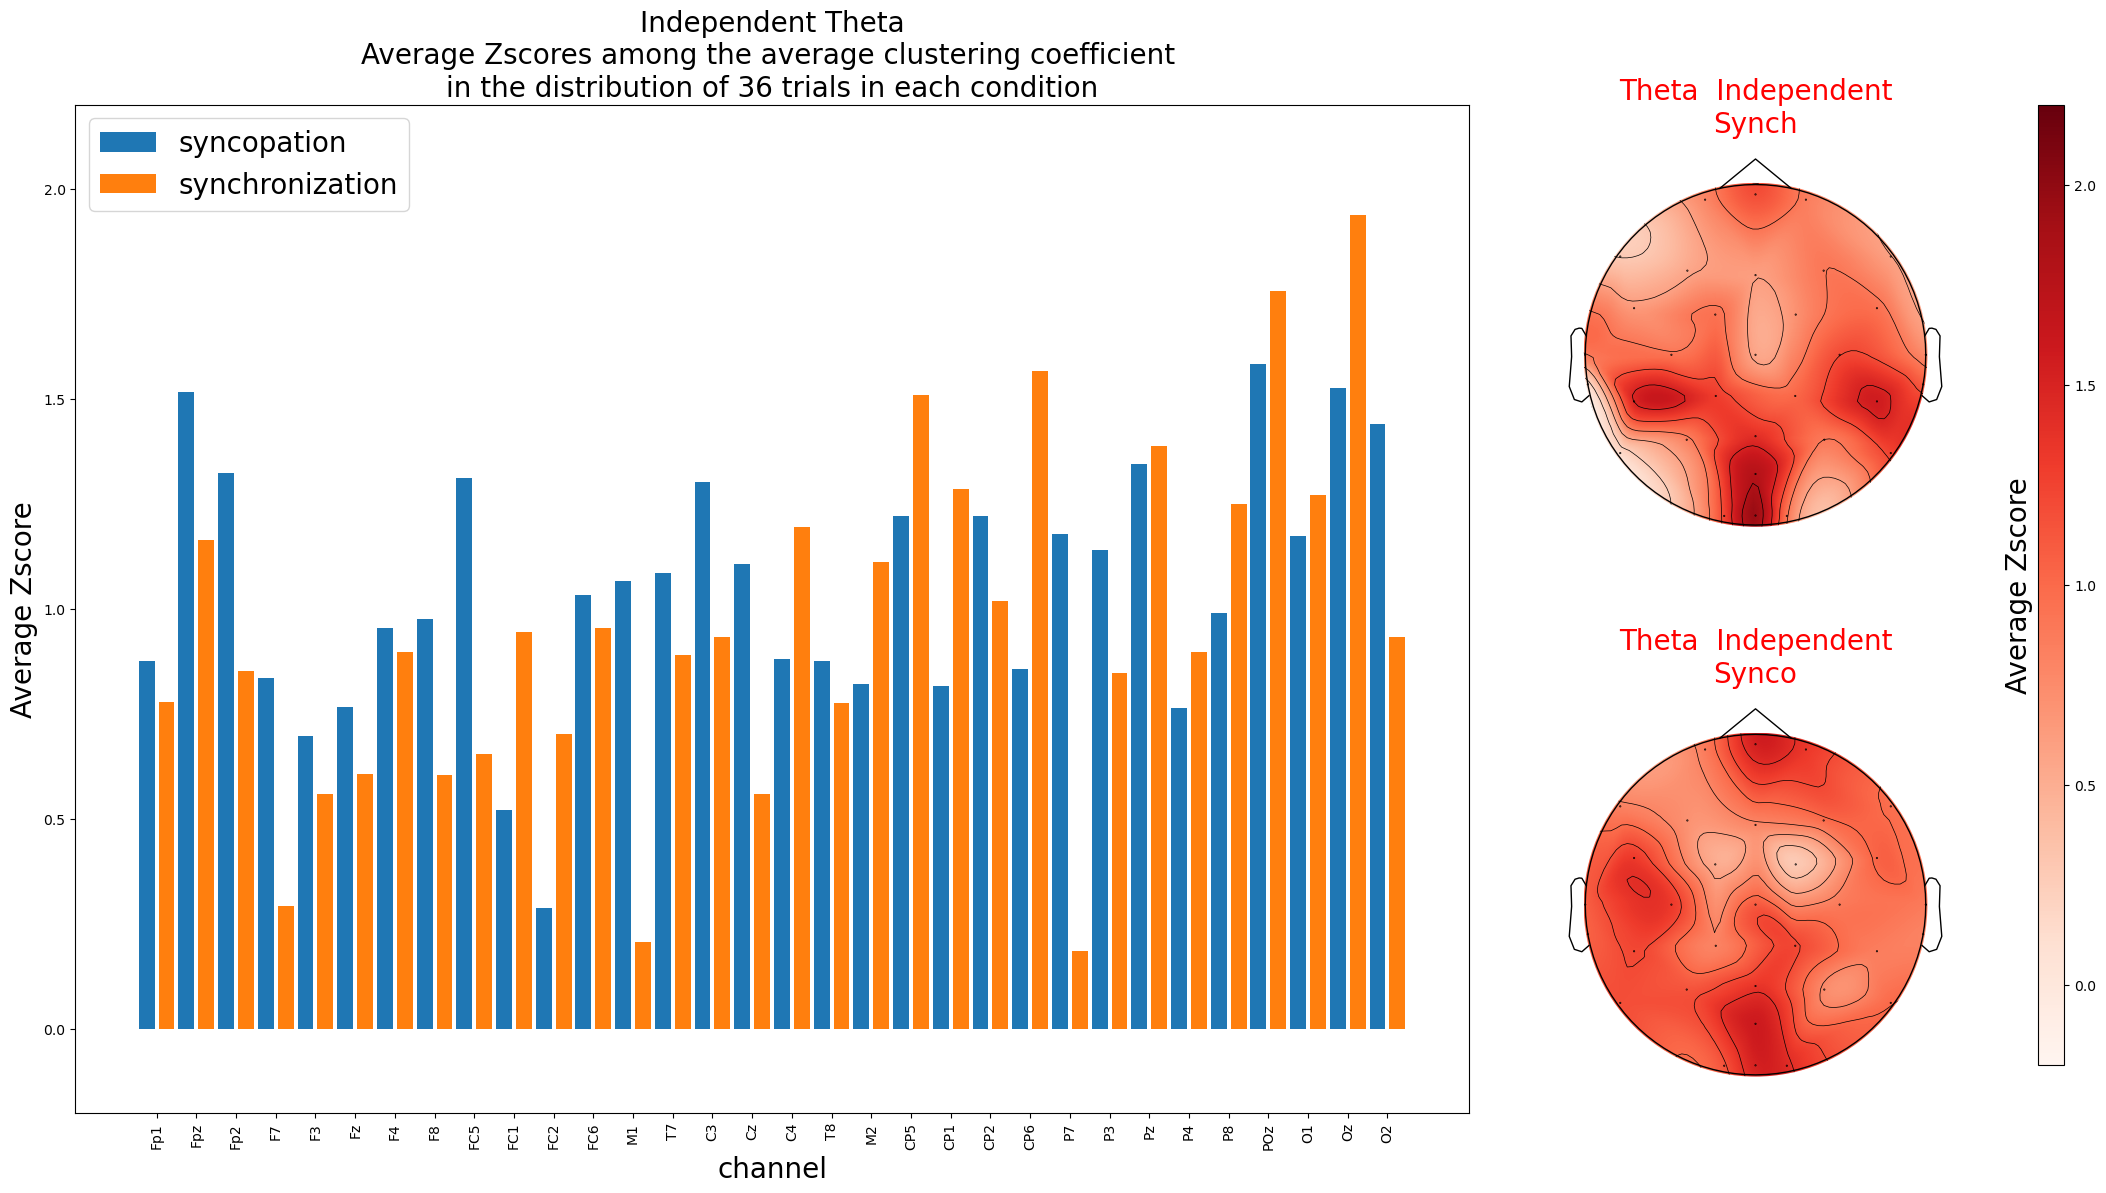

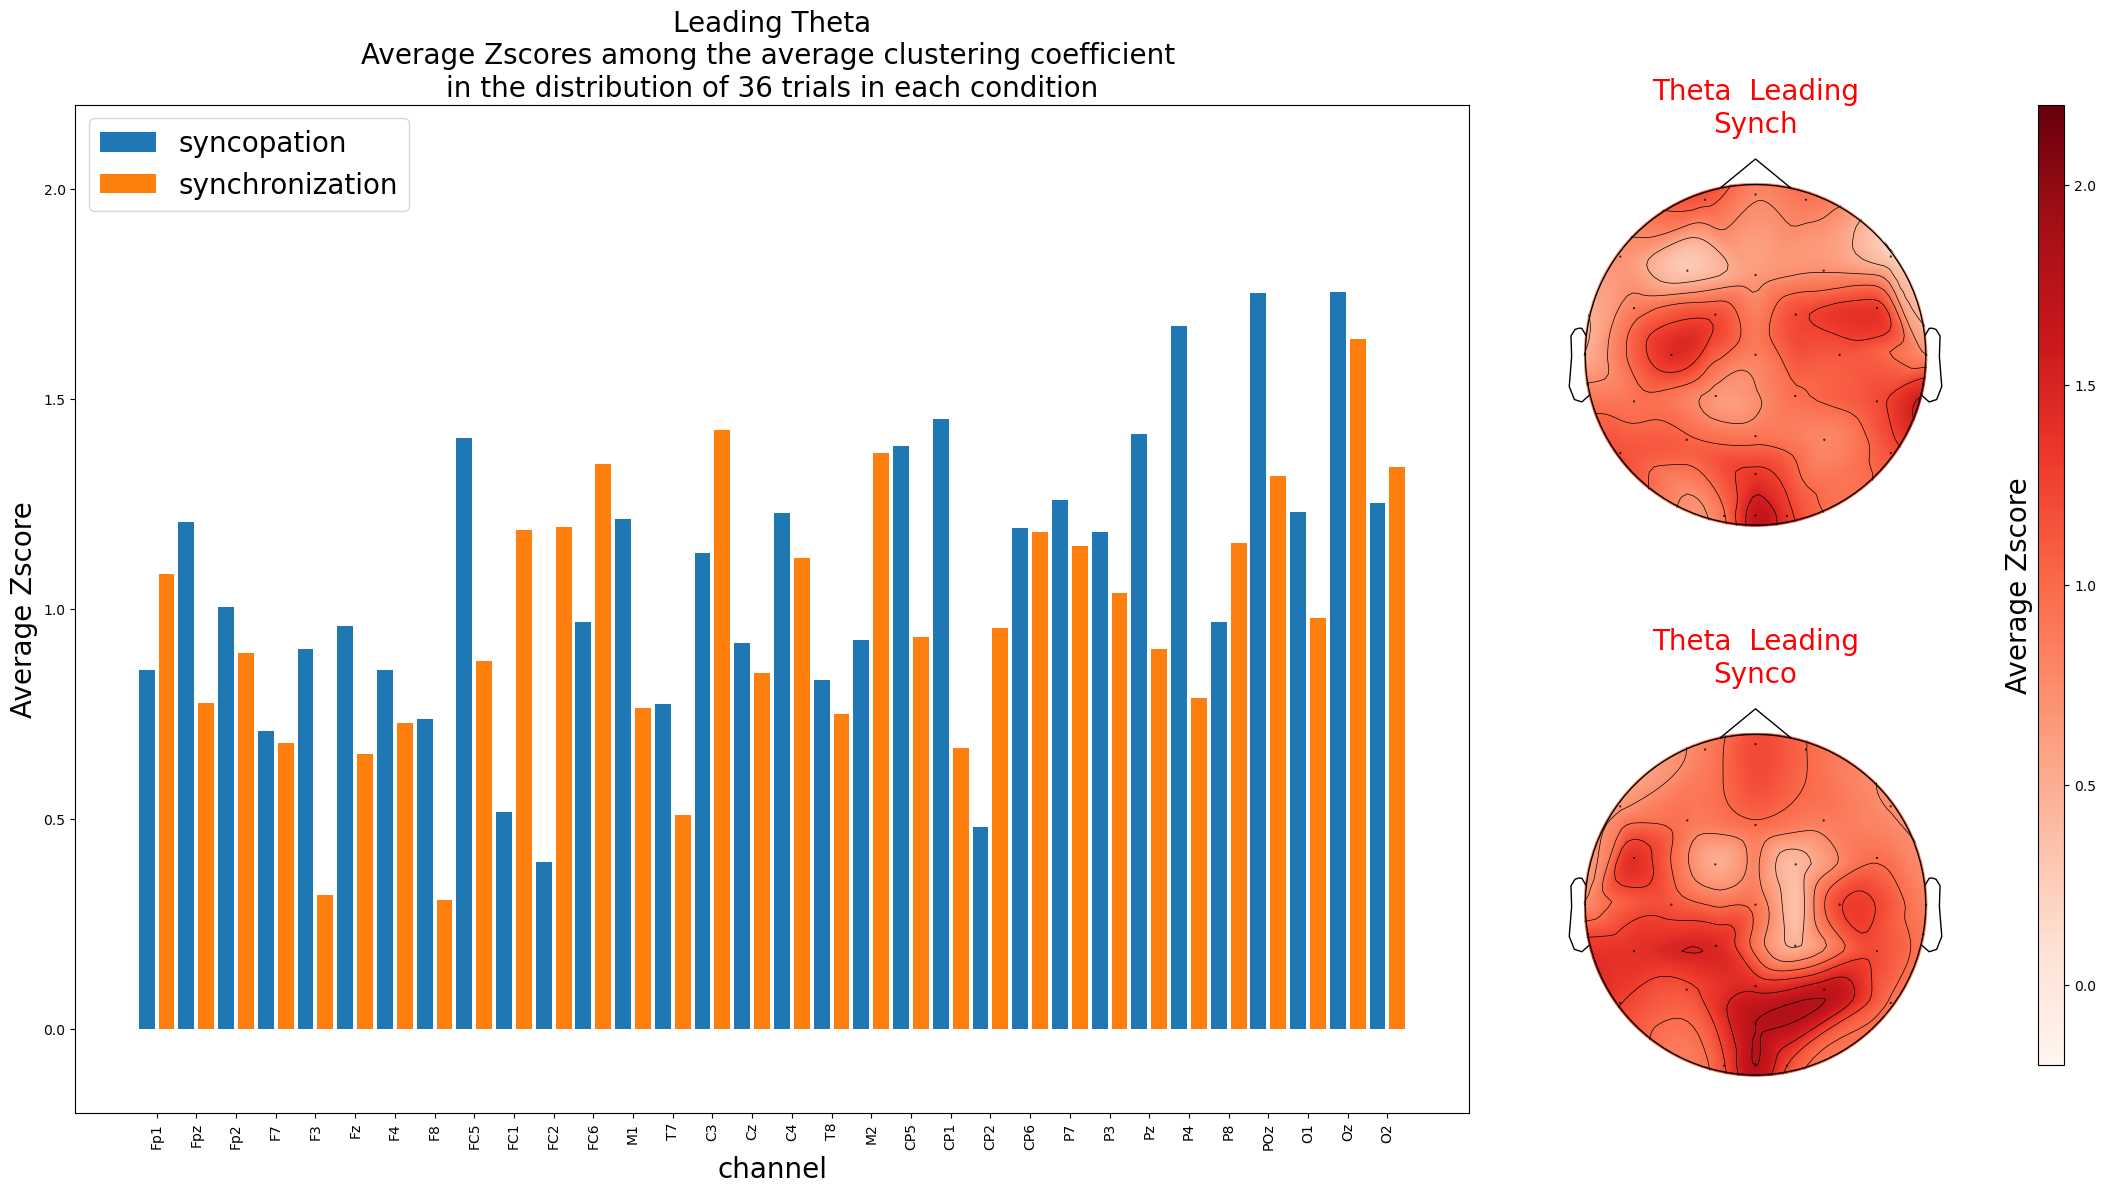

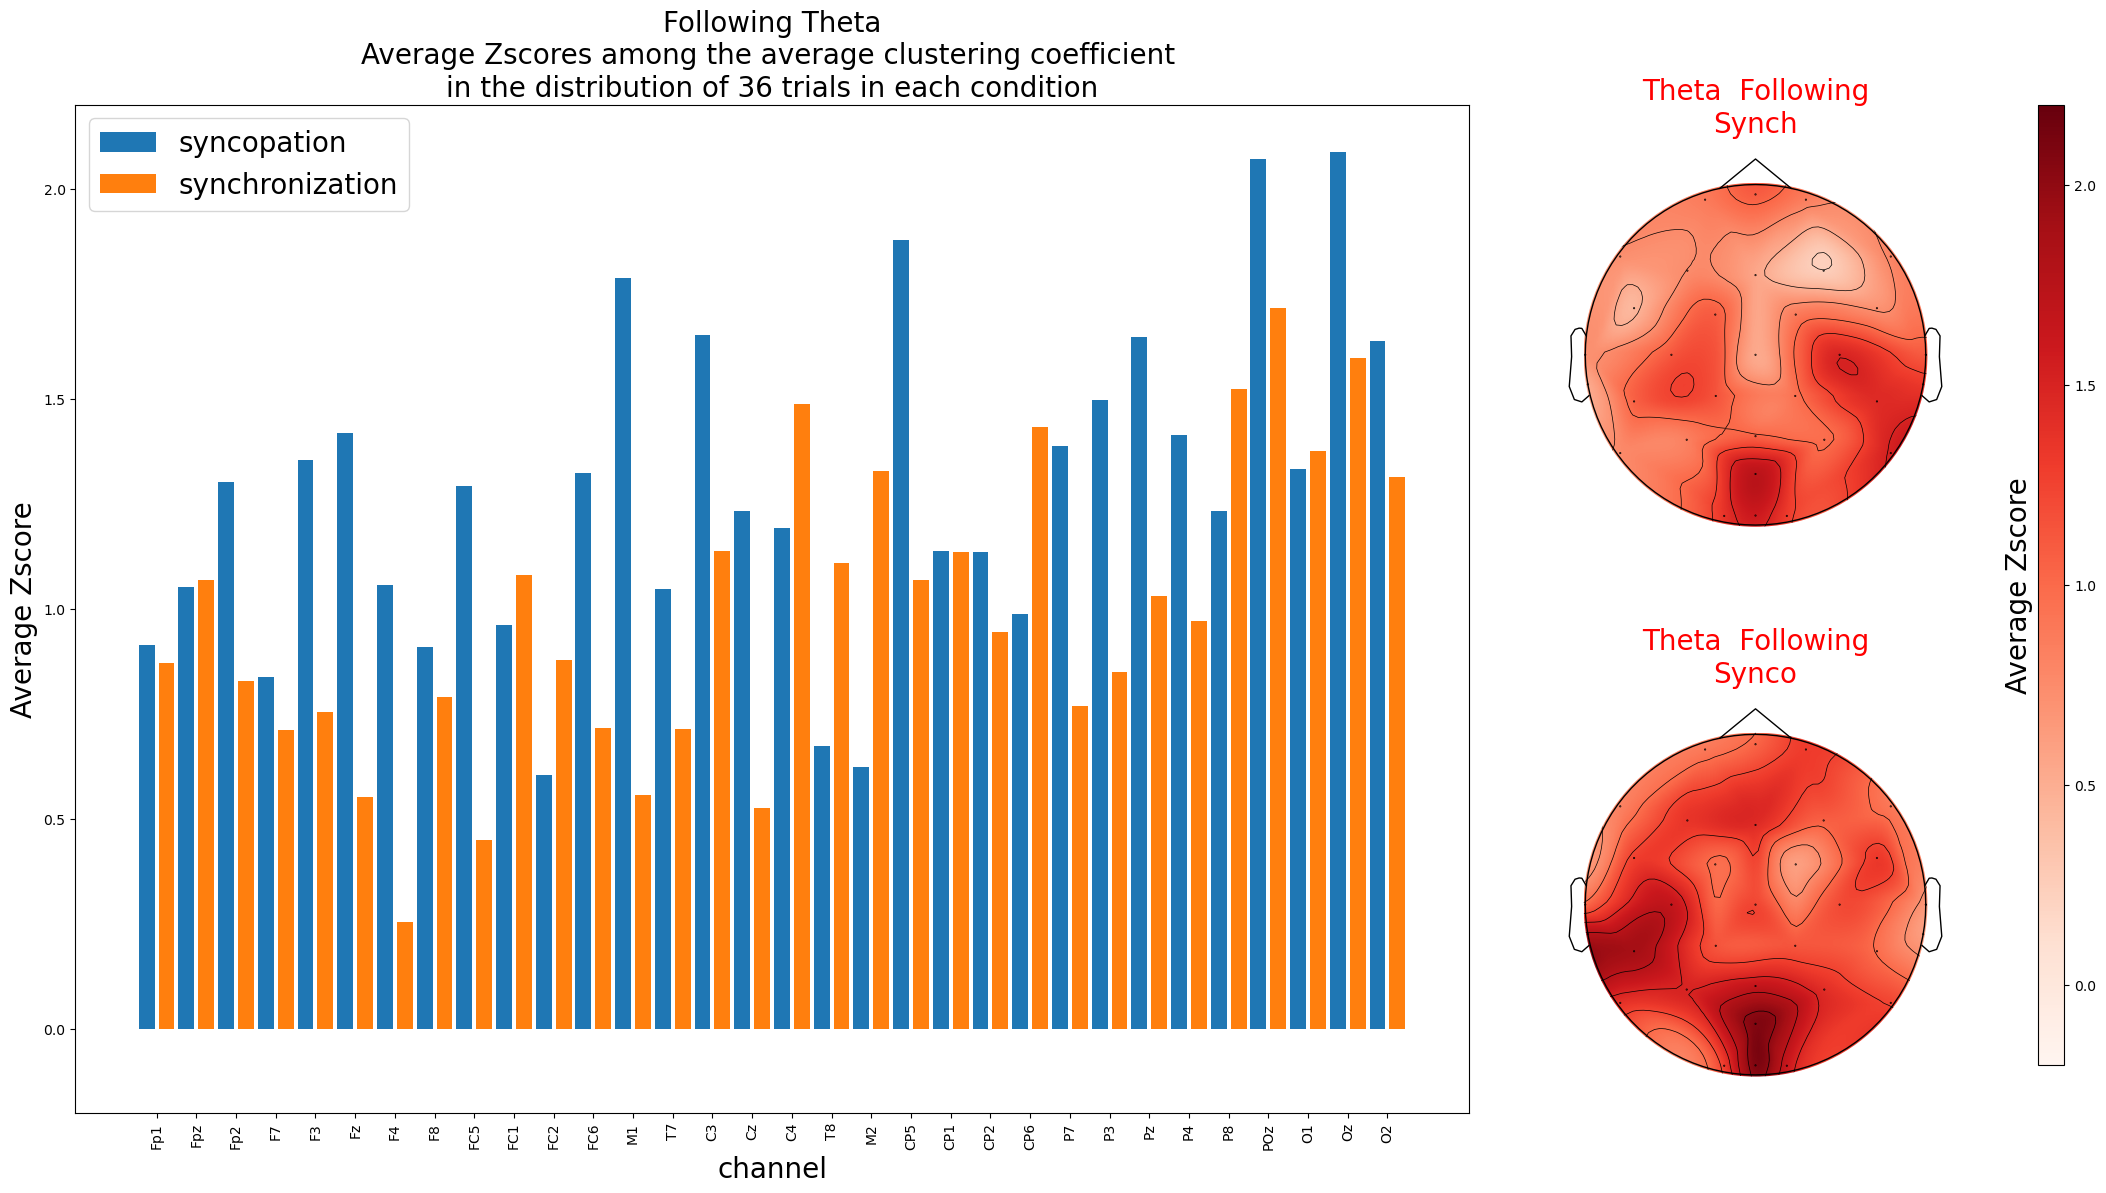

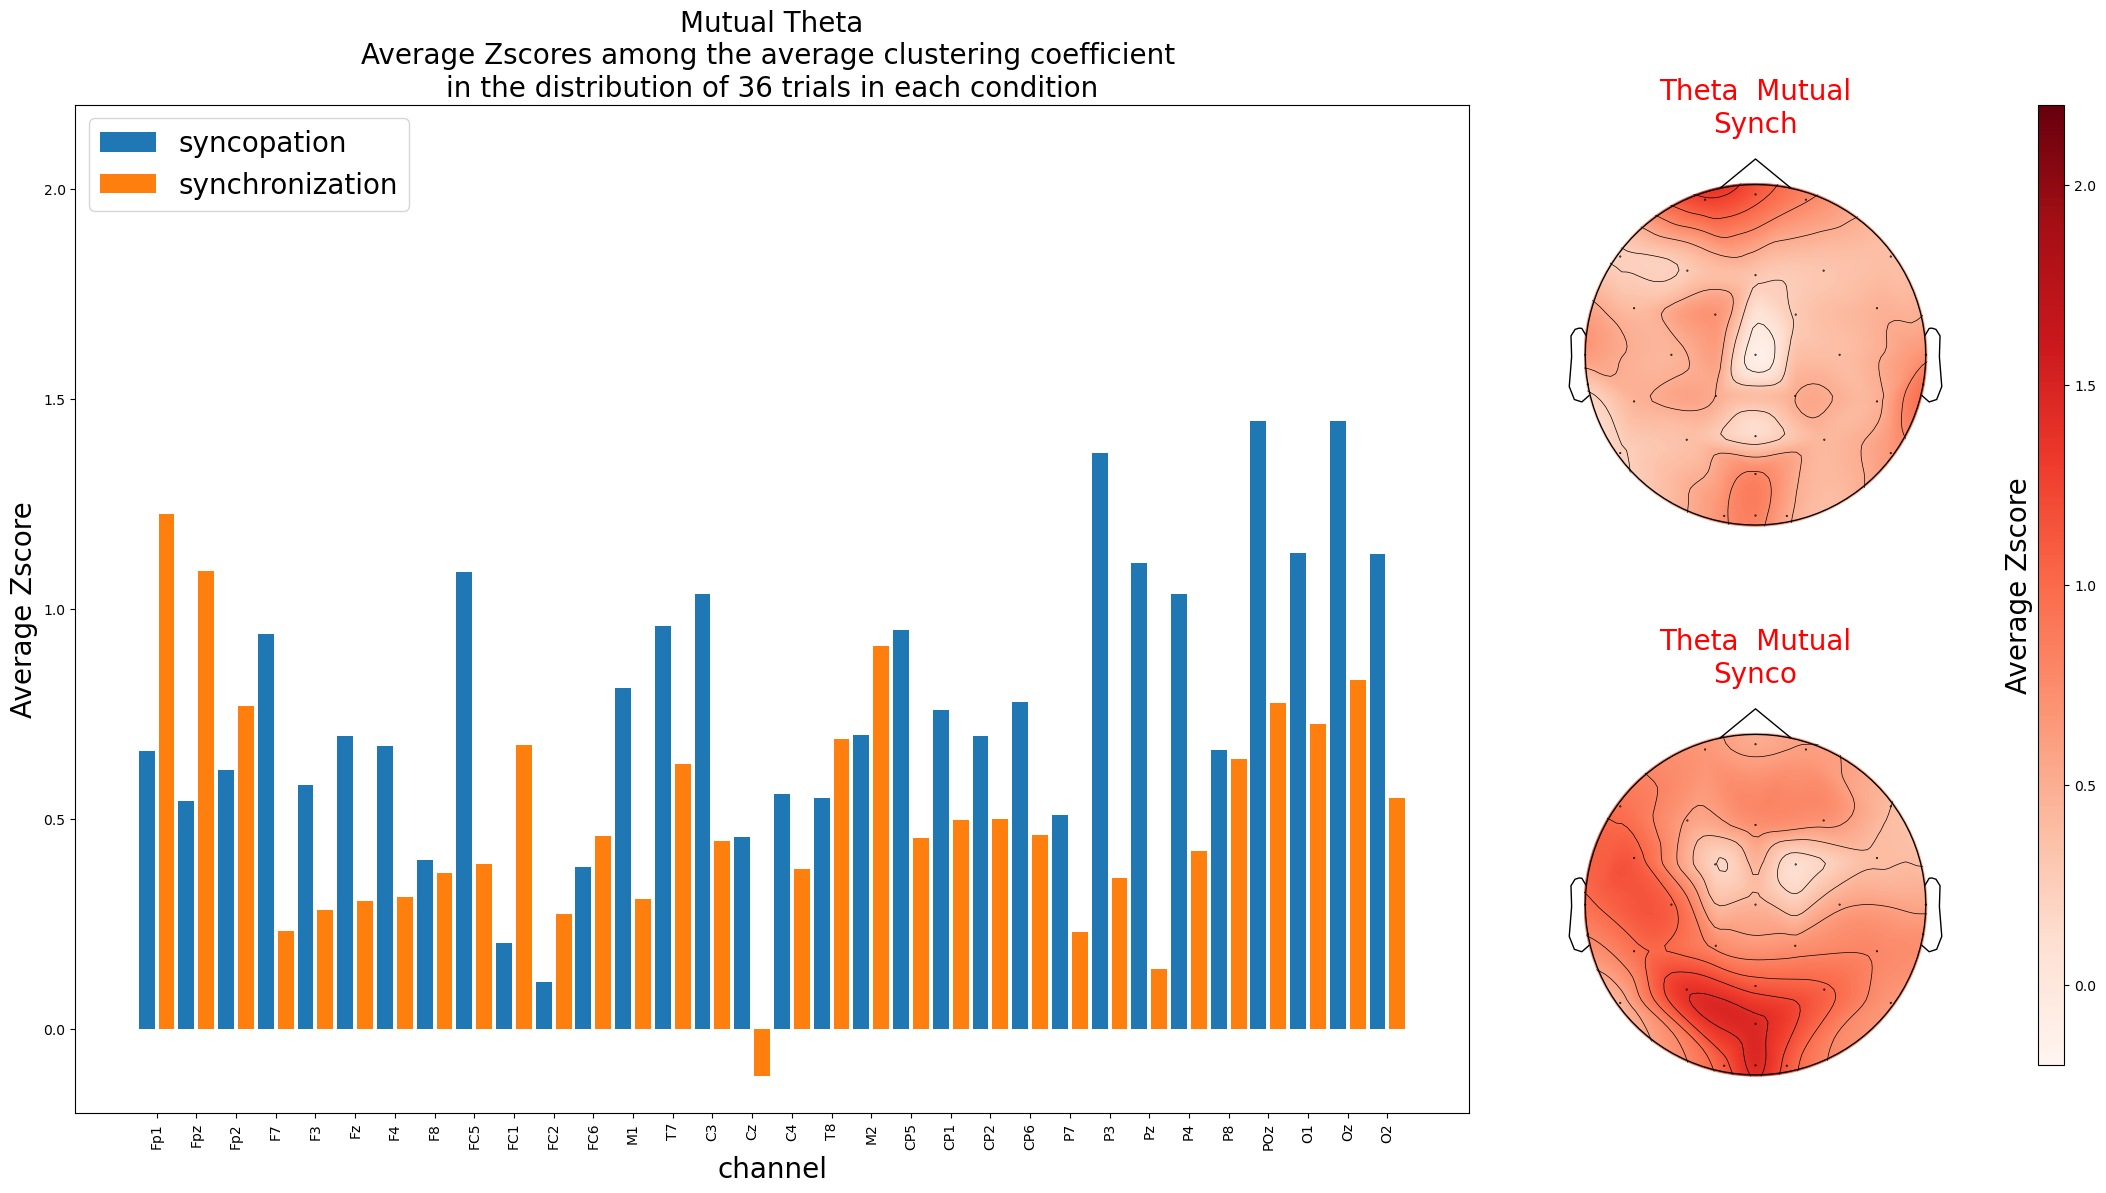

In [12]:
# checking average distribution
# c_random_average=np.zeros((2,4,36,7,32))
# zscore_syn_average=np.zeros((2,4,36,7,32))
freq=1
lowlim=-0.2
highlim=2.2

for st in range(4):
        fig = plt.figure(figsize=(6*4+2, 6*2))
        ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=3, rowspan=2)
        ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 3), colspan=1, rowspan=1)
        ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 3), colspan=1, rowspan=1)

        plt.sca(ax1)
        plt.bar(np.arange(32),np.mean(zscore_syn_average[1,st,:,1,:],axis=0),width = 0.4)
        plt.bar(np.arange(32)+0.5,np.mean(zscore_syn_average[0,st,:,1,:],axis=0),width = 0.4)
        plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
        plt.legend(('syncopation','synchronization'), loc = 'upper left',fontsize=20)
        plt.title(states4names[st] +' ' + band_labels[freq]+'\nAverage Zscores among the average clustering coefficient '
                        +'\nin the distribution of 36 trials in each condition',fontsize=20)
        plt.xlabel('channel',fontsize = 20)
        plt.ylabel('Average Zscore',fontsize = 20)
        plt.ylim(lowlim,highlim)
                
        for syn in range(2):
                ctr32=np.mean(zscore_syn_average[syn,st,:,1,:],axis=0)
                if syn==0:
                        plt.sca(ax2)
                        im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
                                                axes=ax2,cmap='Reds',show=False)
                        ax2.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
                                color=freq7colors[freq],
                                fontsize=20)
                else:
                        plt.sca(ax3)
                        im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
                                                axes=ax3,cmap='Reds',show=False)
                        ax3.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
                                color=freq7colors[freq],
                                fontsize=20)
                        

        fig.subplots_adjust(right=0.85)
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
        cbar_edges=fig.colorbar(im,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        cbar_edges.set_label('Average Zscore',fontsize = 20, rotation=90)
        cbar_edges.ax.yaxis.set_label_position('left')
        # cbar_edges.ax.text(3.8,0.5,'Percentage of trial having clustering coefficient '
        # +str(zscore_limit)+ ' zsocres higher'
        # '\nthan the mean of 1000 random network with the same number of edges',
        # fontsize = 15,rotation=90,va='center')
        # fig.subplots_adjust(top=0.01)
        # plt.suptitle('Percentage of trial having clustering coefficient '+str(zscore_limit)+ ' zsocres higher'
        # '\nthan the mean of 1000 random network with the same number of edges', fontsize = 20) 

In [ ]:
# # checking average Zscore
# freq=1
# lowlim=-0.6
# highlim=3.4

# for st in range(4):
#         fig = plt.figure(figsize=(6*4+2, 6*2))
#         ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=3, rowspan=2)
#         ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 3), colspan=1, rowspan=1)
#         ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 3), colspan=1, rowspan=1)

#         plt.sca(ax1)
#         plt.bar(np.arange(32),zscore_average_syn[1,st,1,:],width = 0.4)
#         plt.bar(np.arange(32)+0.5,zscore_average_syn[0,st,1,:],width = 0.4)
#         plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
#         plt.legend(('syncopation','synchronization'), loc = 'upper left',fontsize=20)
#         plt.title(states4names[st] +' ' + band_labels[freq]+'\nAverage Zscores among the clustering coefficient distribution'
#                         +'\nof 1000 random network with the same number of edges',fontsize=20)
#         plt.xlabel('channel',fontsize = 20)
#         plt.ylabel('Average Zscore',fontsize = 20)
#         plt.ylim(lowlim,highlim)
                
#         for syn in range(2):
#                 ctr32=zscore_average_syn[syn,st,1,:]
#                 if syn==0:
#                         plt.sca(ax2)
#                         im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
#                                                 axes=ax2,cmap='Reds',show=False)
#                         ax2.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
#                                 color=freq7colors[freq],
#                                 fontsize=20)
#                 else:
#                         plt.sca(ax3)
#                         im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
#                                                 axes=ax3,cmap='Reds',show=False)
#                         ax3.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
#                                 color=freq7colors[freq],
#                                 fontsize=20)
                        



#         fig.subplots_adjust(right=0.85)
#         cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
#         cbar_edges=fig.colorbar(im,cbar_ax2)
#         cbar_edges.ax.tick_params(labelsize=10)
#         cbar_edges.set_label('Average Zscore',fontsize = 20, rotation=90)
#         cbar_edges.ax.yaxis.set_label_position('left')
#         # cbar_edges.ax.text(3.8,0.5,'Percentage of trial having clustering coefficient '
#         # +str(zscore_limit)+ ' zsocres higher'
#         # '\nthan the mean of 1000 random network with the same number of edges',
#         # fontsize = 15,rotation=90,va='center')
#         # fig.subplots_adjust(top=0.01)
#         # plt.suptitle('Percentage of trial having clustering coefficient '+str(zscore_limit)+ ' zsocres higher'
#         # '\nthan the mean of 1000 random network with the same number of edges', fontsize = 20) 

In [15]:
# # convert zscore > zscore_bool to boolean 
# zscore_limit = 2
# high_zscore_bool_syn=np.zeros((2,4,36,7,32))
# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):
#                 for chan in range(32):
#                     if zscore_syn[syn,st,tr,freq,chan] > zscore_limit:
#                         high_zscore_bool_syn[syn,st,tr,freq,chan]=1
#                     else:
#                         high_zscore_bool_syn[syn,st,tr,freq,chan]=0
                    

In [269]:
# # convert zscore to boolean
# zscore_limit = 2
# low_zscore_bool_syn=np.zeros((2,4,36,7,32))
# for syn in range(2):
#     for st in range(4):
#         for tr in range(36):
#             for freq in range(7):
#                 for chan in range(32):
#                     if zscore_syn[syn,st,tr,freq,chan] < -1*zscore_limit:
#                         low_zscore_bool_syn[syn,st,tr,freq,chan]=1
#                     else:
#                         low_zscore_bool_syn[syn,st,tr,freq,chan]=0

In [ ]:
# # plot the difference
# for freq in range(7):
#         fig, ax = plt.subplots(1,4,figsize=(6*4+2, 6*1))
#         for st in range(4):
#                 plt.sca(ax[st])
#                 ctr32=np.mean(high_zscore_bool_syn[1,st,:,freq,:],axis=0)-\
#                         np.mean(high_zscore_bool_syn[0,st,:,freq,:],axis=0)
#                 im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(-0.5, 0.5), 
#                                      axes=ax[st],cmap='jet',show=False)
#                 ax[st].set_title(band_labels[freq]+'  Synco-Synch\n'+states4names[st],
#                           color=freq7colors[freq],
#                           fontsize=20)
                        
#         fig.subplots_adjust(right=0.85)
#         cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
#         cbar_edges=fig.colorbar(im,cbar_ax2)
#         cbar_edges.ax.tick_params(labelsize=10)
#         cbar_edges.set_label('Difference in percentage',fontsize = 20, rotation=90)
#         fig.subplots_adjust(top=0.7)
#         plt.suptitle('Difference in percentage of trial having clustering coefficient '+str(zscore_limit)+ ' zsocres higher'
#         '\nfrom the mean of 1000 random network with the same number of edges', fontsize = 20) 
    

In [ ]:
# # checking
# plt.figure(figsize = (12,6))
# plt.bar(np.arange(32),np.mean(high_zscore_bool_syn[1,3,:,1,:],axis=0),width = 0.4)
# plt.bar(np.arange(32)+0.5,np.mean(high_zscore_bool_syn[0,3,:,1,:],axis=0),width = 0.4)
# plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
# plt.legend(('syncopation','synchronization'), loc = 'upper left')
# plt.title('Mutual ' + band_labels[1]+'\nPercentage of trial having clustering coefficient '
#                 +str(zscore_limit)+ ' zsocres higher'+
#                 '\nthan the mean of 1000 random network with the same number of edges')
# plt.xlabel('channel')
# plt.ylabel('Percentage')
# # plt.ylim((0.2,0.7))

In [ ]:
# for freq in range(7):
#         fig, ax = plt.subplots(2,4,figsize=(6*4+2, 6*2))
#         for syn in range(2):
#                 for st in range(4):
#                         plt.sca(ax[syn,st])
#                         ctr32=np.mean(high_zscore_bool_syn[syn,st,:,freq,:],axis=0)
#                         im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(0.3, 0.7), 
#                                         axes=ax[syn,st],cmap='Reds',show=False)
#                         ax[syn,st].set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
#                                 color=freq7colors[freq],
#                                 fontsize=20)
                                
#                 fig.subplots_adjust(right=0.85)
#                 cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
#                 cbar_edges=fig.colorbar(im,cbar_ax2)
#                 cbar_edges.ax.tick_params(labelsize=10)
#                 cbar_edges.set_label('Percentage',fontsize = 20, rotation=90)
#                 cbar_edges.ax.yaxis.set_label_position('left')
#                 cbar_edges.ax.text(3.8,0.5,'Percentage of trial having clustering coefficient '
#                 +str(zscore_limit)+ ' zsocres higher'
#                 '\nthan the mean of 1000 random network with the same number of edges',
#                 fontsize = 15,rotation=90,va='center')
#                 # fig.subplots_adjust(top=0.01)
#                 # plt.suptitle('Percentage of trial having clustering coefficient '+str(zscore_limit)+ ' zsocres higher'
#                 # '\nthan the mean of 1000 random network with the same number of edges', fontsize = 20) 

In [ ]:
# for freq in range(7):
#         fig, ax = plt.subplots(2,4,figsize=(6*4+2, 6*2))
#         for syn in range(2):
#                 for st in range(4):
#                         plt.sca(ax[syn,st])
#                         ctr32=np.mean(low_zscore_bool_syn[syn,st,:,freq,:],axis=0)
#                         im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(0.1, 0.7), 
#                                         axes=ax[syn,st],cmap='Blues',show=False)
#                         ax[syn,st].set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
#                                 color=freq7colors[freq],
#                                 fontsize=20)
                                
#                 fig.subplots_adjust(right=0.85)
#                 cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
#                 cbar_edges=fig.colorbar(im,cbar_ax2)
#                 cbar_edges.ax.tick_params(labelsize=10)
#                 cbar_edges.set_label('Percentage',fontsize = 20, rotation=90)
#                 cbar_edges.ax.yaxis.set_label_position('left')
#                 cbar_edges.ax.text(3.8,0.3,'Percentage of trial having clustering coefficient '
#                 +str(zscore_limit)+ ' zsocres lower'
#                 '\nthan the mean of 1000 random network with the same number of edges',
#                 fontsize = 15,rotation=90,va='center')
#                 # fig.subplots_adjust(top=0.01)
#                 # plt.suptitle('Percentage of trial having clustering coefficient '+str(zscore_limit)+ ' zsocres lower'
#                 # '\nthan the mean of 1000 random network with the same number of edges', fontsize = 20) 

In [ ]:
# # plot the difference
# for freq in range(7):
#         fig, ax = plt.subplots(1,4,figsize=(6*4+2, 6*1))
#         for st in range(4):
#                 plt.sca(ax[st])
#                 ctr32=np.mean(zscore_bool_syn[1,st,:,freq,:],axis=0)-\
#                         np.mean(zscore_bool_syn[0,st,:,freq,:],axis=0)
#                 im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(-0.5, 0.5), 
#                                      axes=ax[st],cmap='jet',show=False)
#                 ax[st].set_title(band_labels[freq]+'  Synco-Synch\n'+[states4namesst],
#                           color=freq7colors[freq],
#                           fontsize=20)
                        
#         fig.subplots_adjust(right=0.85)
#         cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
#         cbar_edges=fig.colorbar(im,cbar_ax2)
#         cbar_edges.ax.tick_params(labelsize=10)
#         cbar_edges.set_label('Difference in percentage',fontsize = 20, rotation=90)
#         fig.subplots_adjust(top=0.7)
#         plt.suptitle('Difference in percentage of trial having clustering coefficient with '+str(zscore_limit)+ ' zsocres away'
#         '\nfrom the mean of 1000 random network with the same number of edges', fontsize = 20) 
    

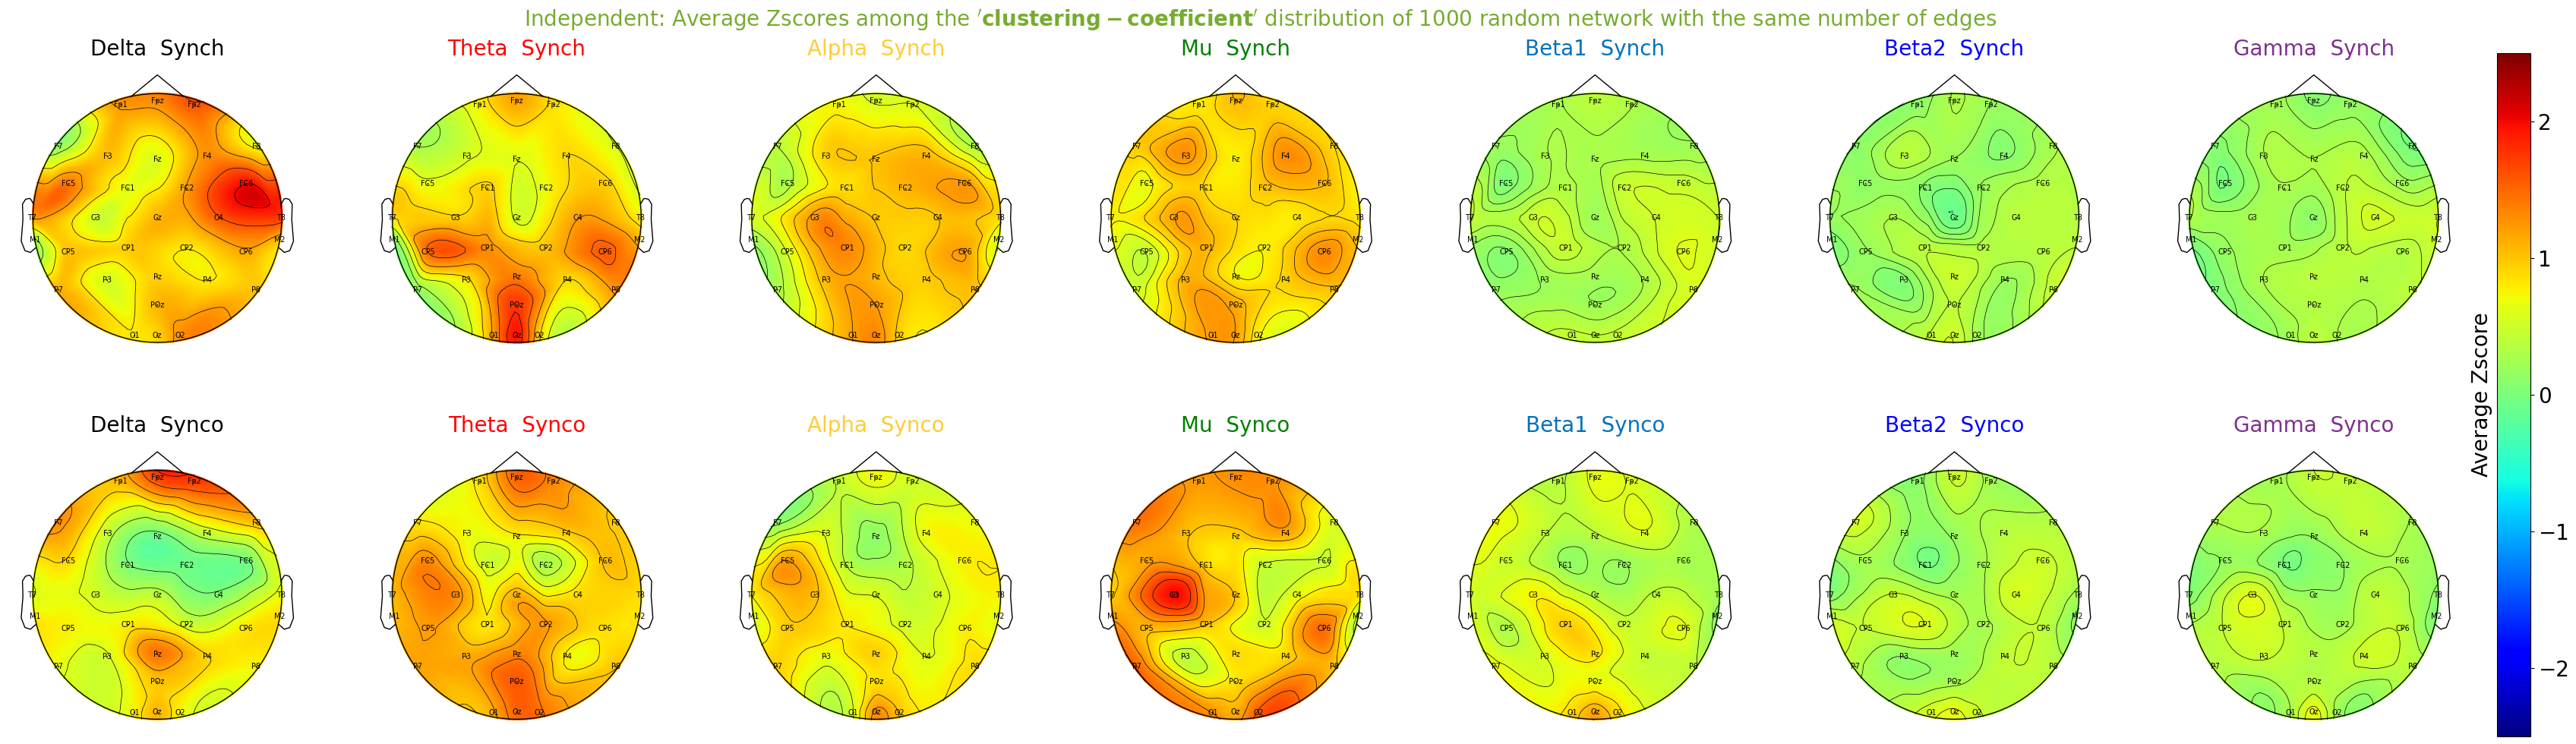

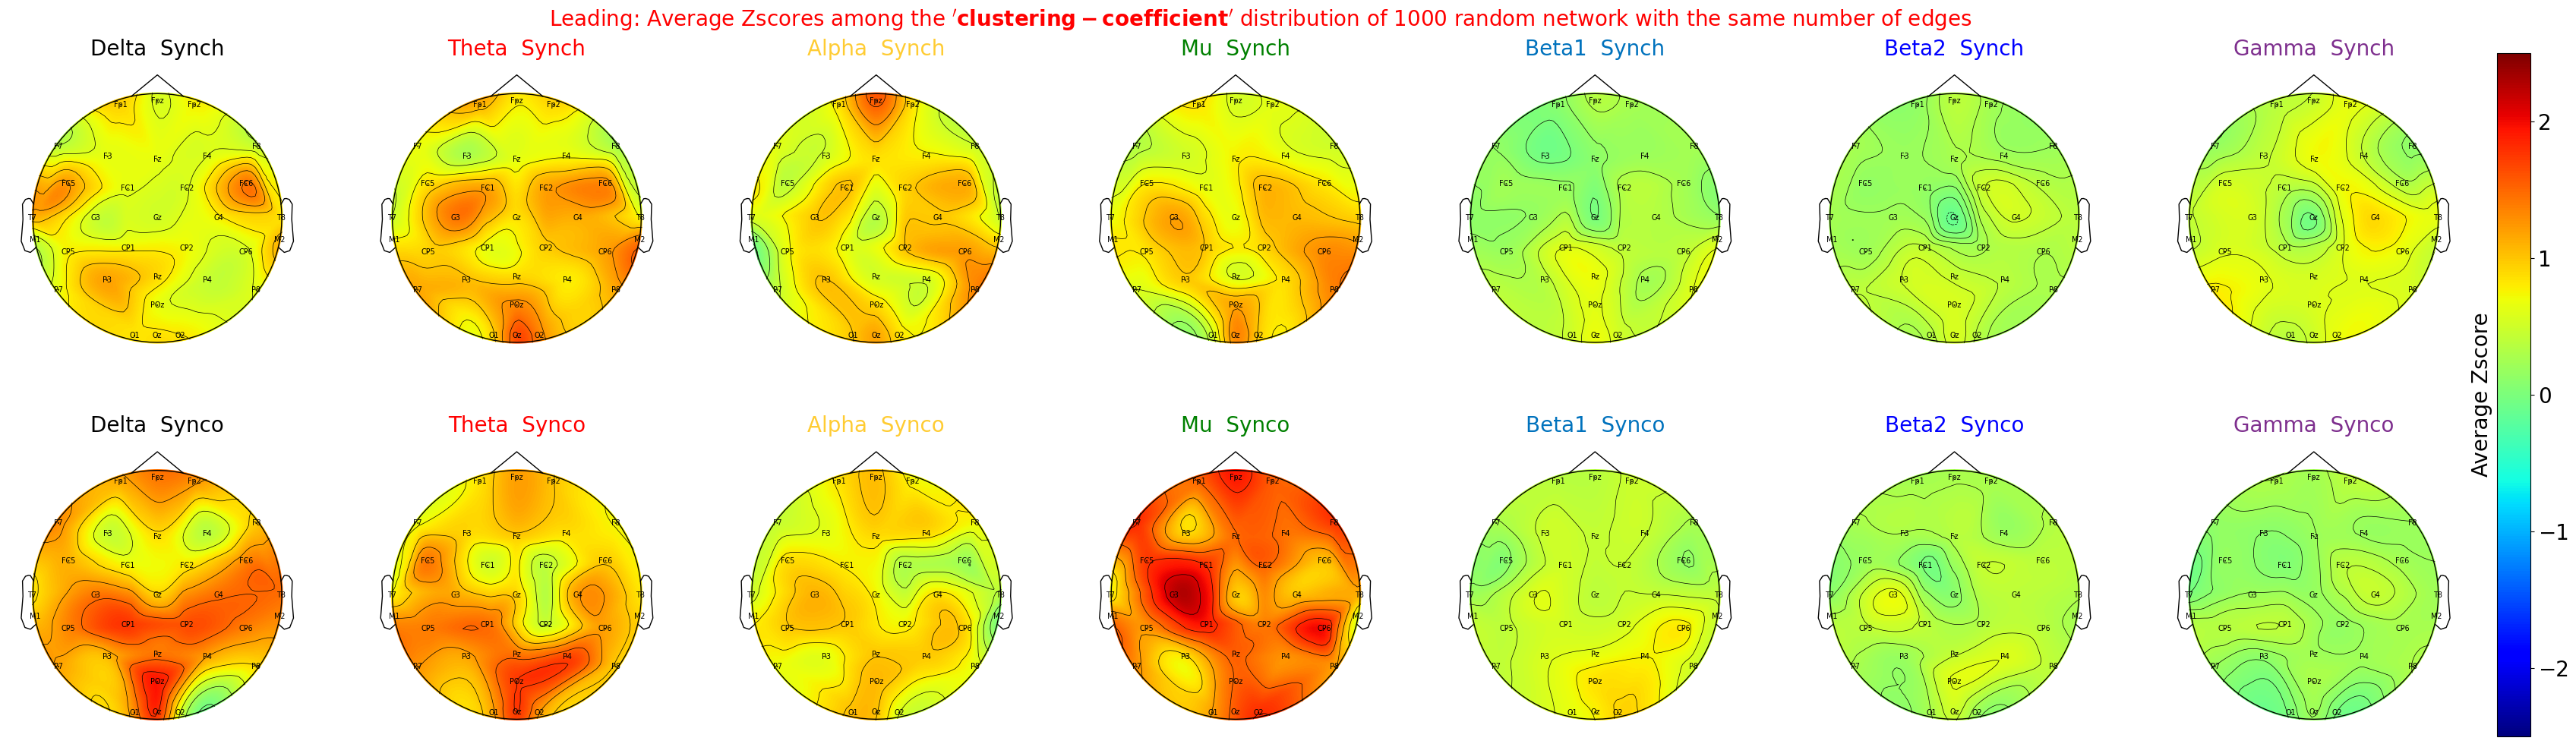

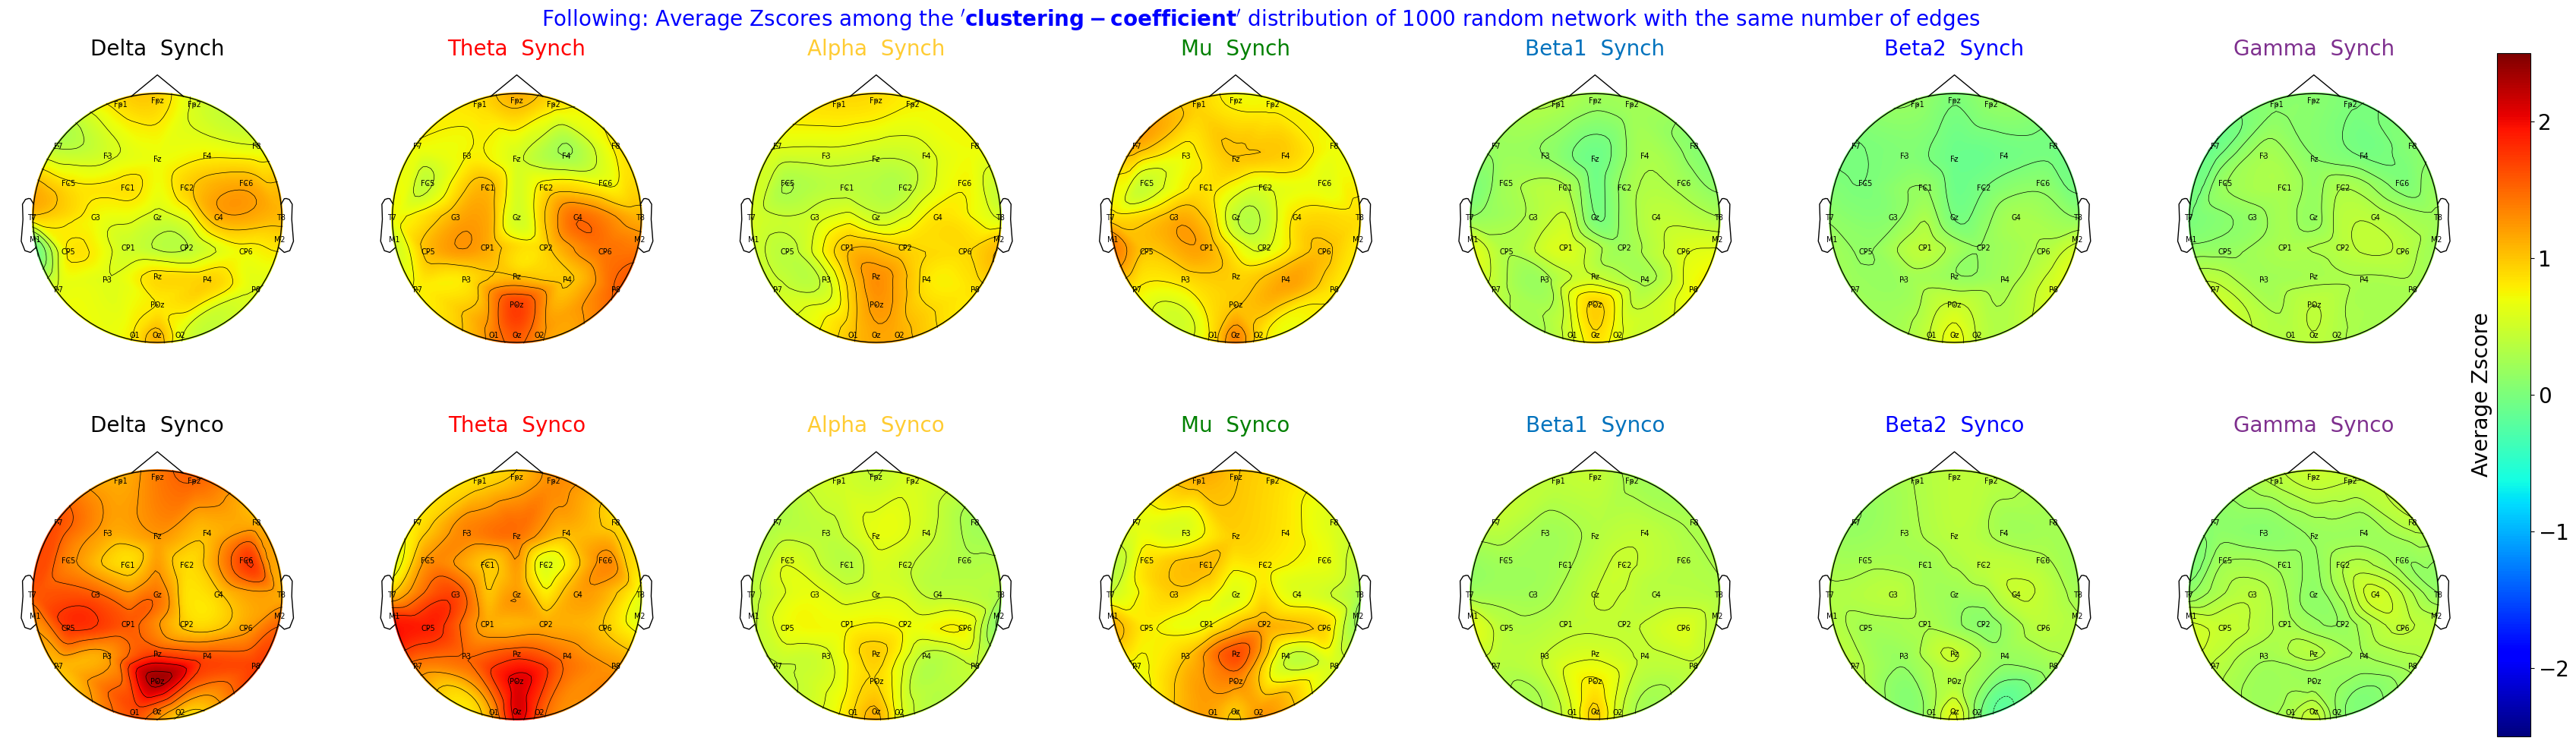

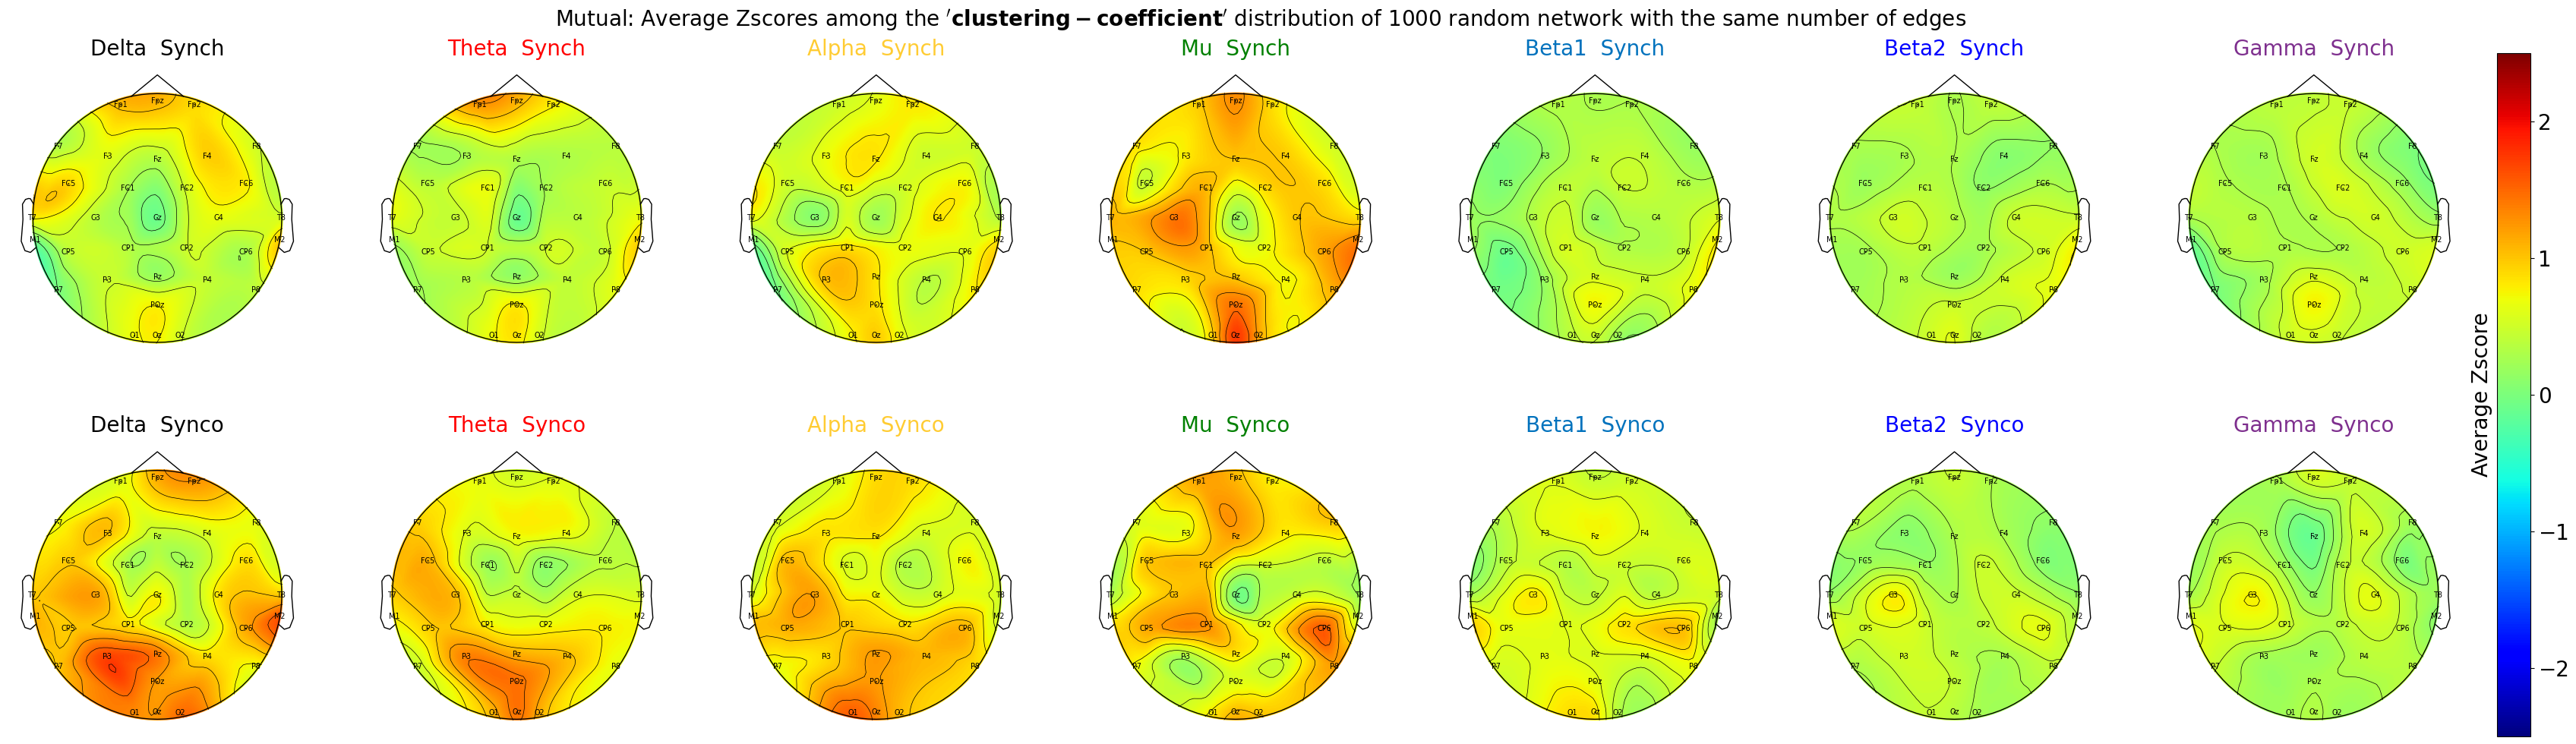

In [16]:
# 7x2 =14plots for each st
lowlim=-2.5
highlim=2.5
for st in range(4):
    fig, ax = plt.subplots(2,7,figsize=(6*7+2, 5*2))
    for syn in range(2):
        for freq in range(7):
            ctr32=np.mean(zscore_syn_average[syn,st,:,freq,:],axis=0)
            im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
                                    axes=ax[syn,freq],cmap='jet',show=False,
                                    ch_type='eeg', sensors=True, names=labels)
            ax[syn,freq].set_title(band_labels[freq]+'  '+syn2names[syn],color=freq7colors[freq],fontsize=20)
                    
    fig.subplots_adjust(right=0.86,top=0.93,bottom=0.02)
    cbar_ax2 = fig.add_axes([0.87, 0.02, 0.01, 0.9])
    cbar_edges=fig.colorbar(im,cbar_ax2)
    cbar_edges.ax.tick_params(labelsize=10)
    cbar_edges.set_label('Average Zscore',fontsize = 20, rotation=90)
    cbar_edges.ax.yaxis.set_label_position('left')
    for t in cbar_edges.ax.get_yticklabels():
        t.set_fontsize(20)

    plt.suptitle(states4names[st]+': Average Zscores among the '+ 
    r"$\bf{'clustering-coefficient'}$"+' distribution of 1000 random network with '+
    'the same number of edges',color=color_4st[st],fontsize=20)


# print into Pdf file
# paffilename = "degree_centrality.pdf"
# save_image(paffilename)